In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting(use_latex=True, pretty_print=False)

# Generalized coordinates

In [2]:
q1, q2, q3 = me.dynamicsymbols('q1, q2, q3')

# Generalized speeds

In [3]:
u1, u2, u3 = me.dynamicsymbols('u1, u2, u3')

# Specified Inputs

In [4]:
F, T = me.dynamicsymbols('F, T')

# Constants

In [5]:
k, c, ma, mb, mc, IB_bo, l, kT, g = sm.symbols('k, c, m_a, m_b, m_c, I_{B_bo}, l, k_T, g')
IB_bo

# Reference Frames

In [6]:
N = me.ReferenceFrame('N')

In [7]:
B = N.orientnew('B', 'Axis', (q2, N.z))

In [8]:
C = B.orientnew('C', 'Axis', (q3, N.z))

# Kinematic Differential Equations

$$
u_i = \dot{q}_i \\
0 = u_i - \dot{q}_i
$$


In [9]:
kdes = [u1 - q1.diff(),
        u2 - q2.diff(),
        u3 - q3.diff()]
kdes

# Angular Velocities

In [10]:
B.set_ang_vel(N, u2 * N.z)

In [11]:
C.set_ang_vel(B, u3 * N.z)

# Points

In [12]:
O = me.Point('O')

In [13]:
Pab = O.locatenew('P_{ab}', q1 * N.x)

In [14]:
Bo = Pab.locatenew('B_o', - 2 * l / 3 * B.y)

In [15]:
Pbc = Pab.locatenew('P_{bc}', -l * B.y)

In [16]:
Pc = Pbc.locatenew('P_c', -l * C.y)

In [17]:
Pc.pos_from(O)

# Linear Velocities

In [18]:
Pab.set_vel(N, u1 * N.x)

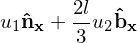

In [19]:
Bo.v2pt_theory(Pab, N, B)

In [20]:
Pbc.v2pt_theory(Pab, N, B)

In [21]:
Pc.v2pt_theory(Pbc, N, C)

# Partial Velocities

In [22]:
Pab.vel(N).diff(u1, N)

In [23]:
Pab.partial_velocity(N, u1)

In [24]:
Pab.partial_velocity(N, u1, u2, u3)

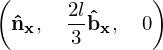

In [25]:
Bo.partial_velocity(N, u1, u2, u3)

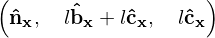

In [26]:
Pc.partial_velocity(N, u1, u2, u3)

In [27]:
B.partial_velocity(N, u1, u2, u3)

In [28]:
[B.ang_vel_in(N).diff(ur, N) for ur in [u1, u2, u3]]

# Angular Accelerations

In [29]:
alpha_B_N = B.ang_acc_in(N)
alpha_B_N

In [30]:
a_Pab_N = Pab.acc(N)
a_Pab_N

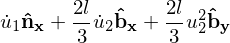

In [31]:
a_Bo_N = Bo.acc(N)
a_Bo_N

In [32]:
a_Pc_N = Pc.acc(N)
a_Pc_N

# Loads (forces and torques)

In [33]:
Rab = (F - k * q1 - c * u1) * N.x
Rab

In [34]:
Rbo = -(mb * g) * N.y
Rbo

In [35]:
Rc = -(mc * g) * N.y
Rc

In [36]:
TB = (T + kT * q3) * N.z
TB

# Mass and Inertia

In [37]:
IB = me.inertia(B, 0, 0, IB_bo)
IB

In [38]:
ma, mc

# Generalized Active Forces

In [39]:
u = [u1, u2, u3]

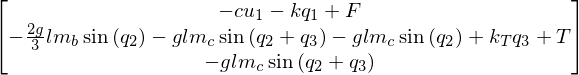

In [40]:
Fr = []

for ur in u:
    Fr.append(Pab.partial_velocity(N, ur).dot(Rab) +
              Pc.partial_velocity(N, ur).dot(Rc) +
              Bo.partial_velocity(N, ur).dot(Rbo) +
              B.partial_velocity(N, ur).dot(TB)
             )
    
Fr = sm.trigsimp(sm.Matrix(Fr))
Fr

# Generalized Inertia Forces

In [41]:
Frstar = []

for ur in u:
    Frstar.append(Pab.partial_velocity(N, ur).dot(-ma * a_Pab_N) +
                  Pc.partial_velocity(N, ur).dot(-mc * a_Pc_N) +
                  Bo.partial_velocity(N, ur).dot(-mb * a_Bo_N) +
                  B.partial_velocity(N, ur).dot(-alpha_B_N.dot(IB) + B.ang_vel_in(N).cross(IB.dot(B.ang_vel_in(N)))))
    
Frstar = sm.trigsimp(sm.Matrix(Frstar))

In [42]:
-alpha_B_N.dot(IB) + B.ang_vel_in(N).cross(IB.dot(B.ang_vel_in(N)))

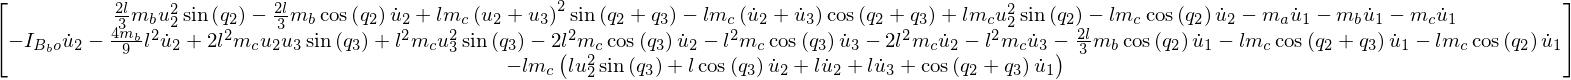

In [43]:
Frstar

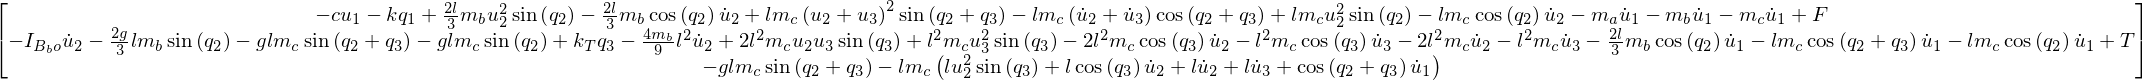

In [44]:
zero = Fr + Frstar
zero

No $\dot{q}$'s!

In [45]:
me.find_dynamicsymbols(zero)

In [46]:
zero.free_symbols

# Explicit First Order Form

$$
\mathbf{F}_r + \mathbf{F}_r^* = 0 \\
\mathbf{F}_r + \mathbf{F}_r^* = \mathbf{M}(\mathbf{q}, t) \dot{\mathbf{u}} - \mathbf{G}(\mathbf{q}, \mathbf{u}, t) = 0 \\
\dot{\mathbf{u}} = \mathbf{M}^{-1} \mathbf{G}
$$

In [47]:
u

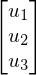

In [48]:
u = sm.Matrix(u)
u

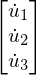

In [49]:
u.diff()

In [50]:
M = zero.jacobian(u.diff())

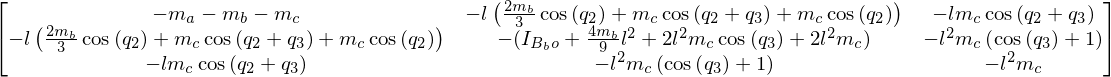

In [51]:
sm.trigsimp(M)

In [52]:
M.shape

In [53]:
me.find_dynamicsymbols(M)

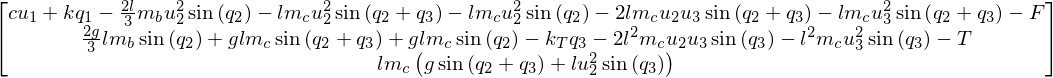

In [54]:
G = -(zero - M * u.diff())
sm.trigsimp(G)

In [55]:
udot = M.LUsolve(G)
# udot  # print if you are brave!

# Easy way to get EoMs

In [56]:
slider = me.Particle('slider', Pab, ma)
bob = me.Particle('bob', Pc, mc)

In [57]:
pend = me.RigidBody('pend', Bo, B, mb, (IB, Bo))

In [58]:
bodies = [slider, bob, pend]

In [59]:
loads = [(Pab, Rab),
         (Pc, Rc),
         (Bo, Rbo),
         (B, TB)]

In [60]:
q = sm.Matrix([q1, q2, q3])

In [61]:
kane = me.KanesMethod(N, q, u, kd_eqs=kdes)

In [62]:
Fr, Frstar = kane.kanes_equations(bodies, loads)

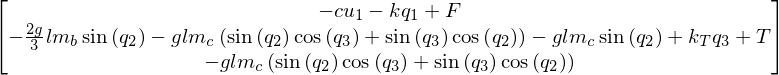

In [63]:
Fr

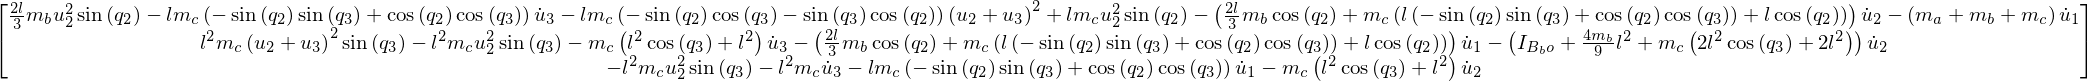

In [64]:
Frstar

$\mathbf{M}$

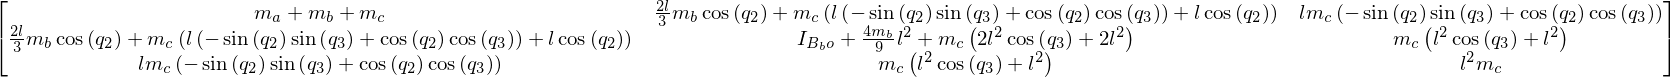

In [65]:
kane.mass_matrix

$\mathbf{G}$

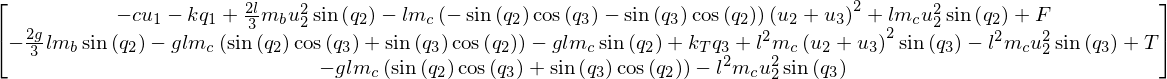

In [66]:
kane.forcing